In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

import vb_lib.structure_optimization_lib as s_optim_lib
import vb_lib.functional_perturbations_lib as fpert_lib
from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul


from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Load data

In [3]:
# data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data_file='/accounts/grad/runjing_liu/BNP/fastStructure/hgdp_data/' + \
            'huang2011_plink_files/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [5]:
print(n_obs)
print(n_loci)

1107
2810


# Load initial fit and model parameters

In [6]:
# fits_dir = '../fits/tmp/' 
# filename = fits_dir + 'simulated_fit_alpha6.0.npz'

fits_dir = '../fits/fits_20201122/'
filename = fits_dir + 'huang2011_fit_alpha6.0.npz'

In [7]:
vb_opt_dict, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, init_fit_meta_data = \
            structure_model_lib.load_structure_fit(filename)

alpha0 = prior_params_dict['dp_prior_alpha']
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Check out the fit

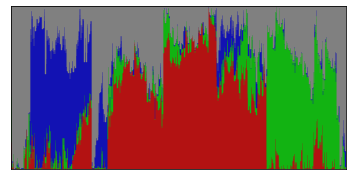

In [8]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]
# re-order individuals for better plotting
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

f, axarr = plt.subplots(1, 1, figsize=(6, 3))
e_ind_admix = plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 3)

# Load linear response derivatives and influence function

In [9]:
# lr_file = 'simulated_fit_alpha{:.1f}_lrderivatives.npz'.format(alpha0[0])
lr_file = 'huang2011_fit_alpha{:.1f}_lrderivatives.npz'.format(alpha0[0])

lr_data = np.load(fits_dir + lr_file)
assert lr_data['alpha0'] == alpha0
assert np.all(lr_data['vb_opt'] == vb_opt)
assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8

print('derivative time: {:.3f}secs'.format(lr_data['lr_time_alpha']))

derivative time: 1322.618secs


# Plot influence function

In [10]:
logit_v_grid = np.array(lr_data['logit_v_grid'])
influence_grid = np.array(lr_data['influence_grid'])

In [11]:
# set up worst-case perturbation
delta = 1.0
worst_case_pert = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                      logit_v_grid = np.array(logit_v_grid), 
                                                      cached_influence_grid = np.array(influence_grid))

### Plot influence function

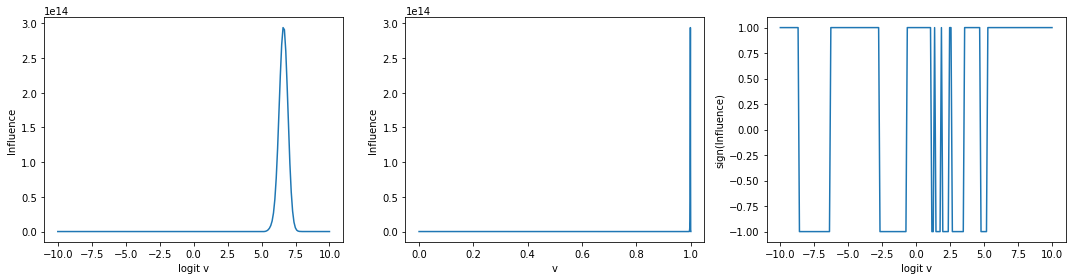

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 
ax[0].plot(worst_case_pert.logit_v_grid, worst_case_pert.influence_grid)
ax[0].set_xlabel('logit v')
ax[0].set_ylabel('Influence')

ax[1].plot(worst_case_pert.v_grid, worst_case_pert.influence_grid)
ax[1].set_xlabel('v')
ax[1].set_ylabel('Influence')

ax[2].plot(worst_case_pert.logit_v_grid, np.sign(worst_case_pert.influence_grid))
ax[2].set_xlabel('logit v')
ax[2].set_ylabel('sign(Influence)')

fig.tight_layout()

# Plot prior perturbation

In [13]:
# just for plotting only! 
# saves some time in computing the influence function
# by doing a setp function interpolation
def influence_fun_interp(logit_v): 
    # find index of logit_v_grid 
    # closest (on the left) to logit_v
    indx = np.searchsorted(worst_case_pert.logit_v_grid, logit_v)
    
    # return the influence function at those points
    return worst_case_pert.influence_grid[indx]

# define log phi
def log_phi(logit_v):
    return(np.sign(influence_fun_interp(logit_v)) * worst_case_pert.delta)

In [14]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.967512e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.752151e-01
  warnings.warn(


Text(0.5, 1.0, 'Priors in logit space')

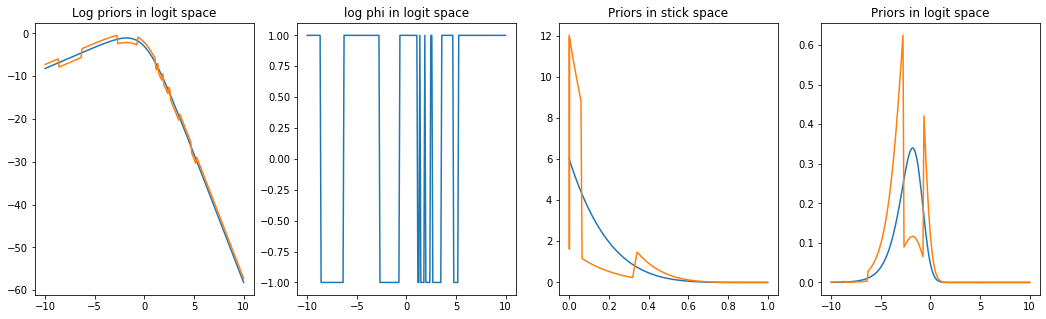

In [15]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = worst_case_pert.logit_v_grid
v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [16]:
f_obj = fpert_lib.FunctionalPerturbationObjectives(worst_case_pert.get_e_log_linf_perturbation,
                                                   vb_params_paragami)

# Load all epsilon fits

In [17]:
# filenames = 'simulated_fit_pertwc*'
filenames = 'huang2011_fit_pertwc*'

In [18]:
import os 
import re

In [19]:
files = [f for f in os.listdir(fits_dir) if re.match(filenames, f)]

In [20]:
files

['huang2011_fit_pertwc8.npz',
 'huang2011_fit_pertwc6.npz',
 'huang2011_fit_pertwc1.npz',
 'huang2011_fit_pertwc0.npz',
 'huang2011_fit_pertwc7.npz',
 'huang2011_fit_pertwc9.npz',
 'huang2011_fit_pertwc4.npz',
 'huang2011_fit_pertwc3.npz',
 'huang2011_fit_pertwc10.npz',
 'huang2011_fit_pertwc2.npz',
 'huang2011_fit_pertwc5.npz']

In [21]:
vb_refit_list = []
epsilon_vec = onp.zeros(len(files))

for i in range(len(files)): 
    
    print('loading fit from: ', files[i])
    
    # load fit
    vb_params_dict, vb_params_paragami, meta_data = \
        paragami.load_folded(fits_dir + files[i])
        
    kl = structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                                    gh_loc, gh_weights, 
                                    e_log_phi = lambda means, infos : \
                                                    f_obj.e_log_phi_epsilon(means, 
                                                                           infos, 
                                                                           meta_data['epsilon']))
    
    assert np.abs(kl - meta_data['final_kl']) < 1e-8
    
    # save alpha and fitted parametrs
    epsilon_vec[i] = meta_data['epsilon']
    vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
epsilon_vec = np.array(epsilon_vec)
vb_refit_list = np.array(vb_refit_list)

loading fit from:  huang2011_fit_pertwc8.npz
loading fit from:  huang2011_fit_pertwc6.npz
loading fit from:  huang2011_fit_pertwc1.npz
loading fit from:  huang2011_fit_pertwc0.npz
loading fit from:  huang2011_fit_pertwc7.npz
loading fit from:  huang2011_fit_pertwc9.npz
loading fit from:  huang2011_fit_pertwc4.npz
loading fit from:  huang2011_fit_pertwc3.npz
loading fit from:  huang2011_fit_pertwc10.npz
loading fit from:  huang2011_fit_pertwc2.npz
loading fit from:  huang2011_fit_pertwc5.npz


In [31]:
# for convenience, sort the epsilons 
_indx = np.argsort(epsilon_vec)
epsilon_vec = epsilon_vec[_indx]
vb_refit_list = vb_refit_list[_indx]

In [32]:
print('epsilons: ', epsilon_vec)

epsilons:  [0.00826446 0.03305785 0.07438017 0.1322314  0.20661157 0.29752066
 0.40495868 0.52892562 0.66942149 0.82644628 1.        ]


# Check free parameters

In [24]:
def predict_opt_par_from_hyper_par(epsilon): 
    return vb_opt + lr_data['dinput_dfun_wc'] * epsilon

In [25]:
lr_list = []

for epsilon in epsilon_vec: 
    
    # get linear response
    lr_list.append(predict_opt_par_from_hyper_par(epsilon))
    

In [26]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')
    

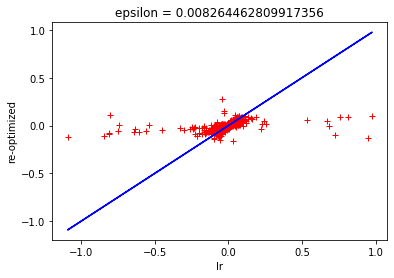

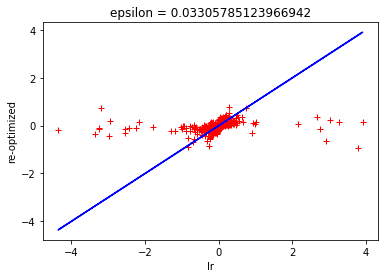

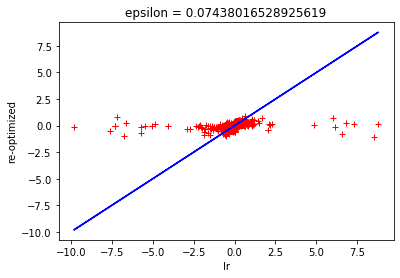

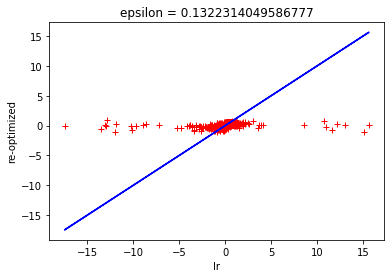

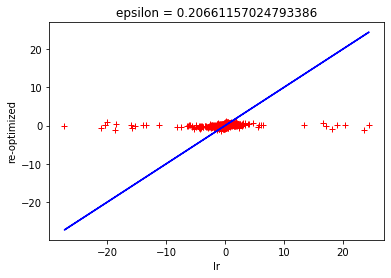

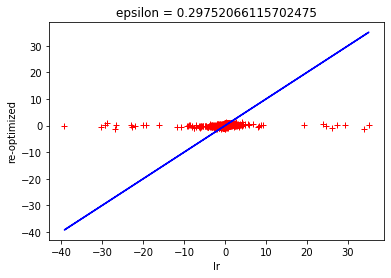

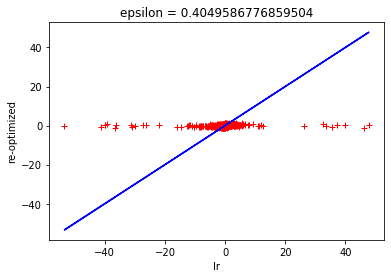

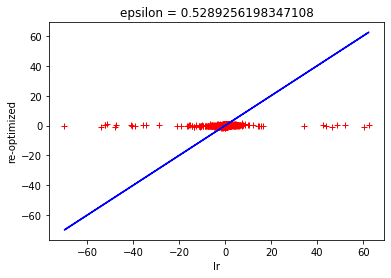

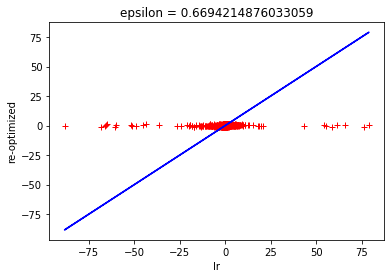

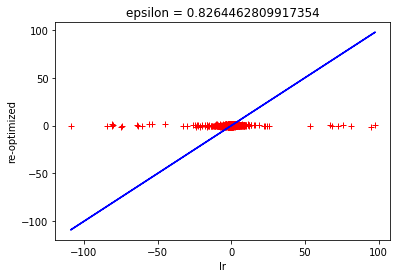

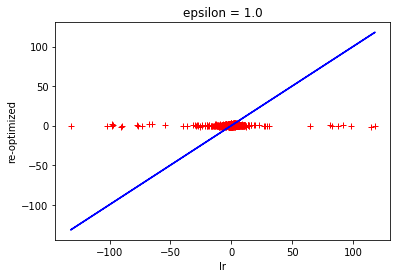

In [27]:
for i in range(len(epsilon_vec)): 
    plt.figure()
    print_diff_plot(lr_list[i], 
                    vb_refit_list[i], 
                    vb_opt)
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

# Number of clusters

In [37]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                       key = key,
                                                       n_samples = 1000)



In [38]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_vec))

for i in range(len(epsilon_vec)): 
    print(i)
        
    # get number of clusters
    refit_e_num_clusters_vec[i] = g(vb_refit_list[i], vb_params_paragami)
    lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)


0
1
2
3
4
5
6
7
8
9
10


# Results

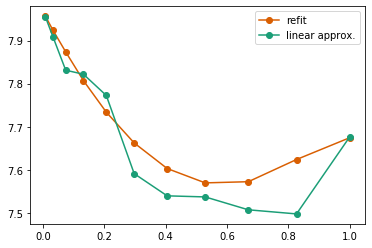

In [39]:
plt.plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

plt.plot(epsilon_vec, lr_e_num_clusters_vec, 
           'o-', color = '#1b9e77', 
           label = 'linear approx.')

plt.legend()